In [1]:
%matplotlib inline
from urllib.request import urlopen
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import bs4
import re

In [2]:
class job_scraper:
    
    def __init__(self):
        self.job = None
        self.location = None
        self.job_links = []
        self.next_link = None
        self.count = 0
        self.json_list = []
        self.jobs_parsed = 0
        self.all_words = []
        self.skills_dict = None
        self.skill_frame = None
        self.fig = None
        self.short_words = []  # DEBUGGING
        
    """Generates a url for the initial search based on job title with an optional location field"""
    def url_gen(self, job, location=None):
        self.job = job
        self.location = location
        job = job.replace(' ', '+')
        url = 'https://www.indeed.com/jobs?q=' + job
        if location:
            try: 
                city, state = location.split(', ')
                if (' ' in city) == True:
                    city = city.replace(' ', '+')
                url += '&l=' + city + '%2C' + state
            except ValueError:    
                if (' ' in location) == True:
                    location = location.replace(' ', '+')
                url += '&l=' + location
        return url
    
    # MAYBE CHECK TO MAKE SURE THE LOCATION IS WHAT YOU SEARCHED
    # REcursive method
    '''A recusrive method that uses the initial url to search over a number of job links (num_links is 10 as default) and
       creates a list of JSON objects, self.json_list, where a JSON object contains the company, job title, and job link 
       for a unique job listing'''
    def job_search(self, url, num_links=10):
        if (num_links==0) | (num_links%10!=0):
            raise ValueError('Invalid number of jobs to search')     
        try:
            source = urlopen(url)
        except urllib.error.HTTPError:
            print('HTTP ERROR')
        except urllib.error.URLError:
            print('URL ERROR')
        soup = bs4.BeautifulSoup(source, 'html.parser')        
        if self.next_link == None:
            next_link = 'https://www.indeed.com' + soup.find_all('span', attrs={'class':'pn'}).pop().findParent().get('href')
            next_link_list = list(next_link)
            self.next_link = ''.join(next_link_list[:-2])
        jobs = soup.find_all('div', attrs={'data-tn-component': 'organicJob'})
        for x in jobs:
            self.job_links.append('https://www.indeed.com' + x.find('a', attrs={'class':'turnstileLink'}).get('href'))
            job_json = {'Company':x.find('span', attrs={"itemprop":"name"}).text.strip(),
                       'Job':x.find('a', attrs={'data-tn-element': "jobTitle"}).text.strip(),
                       'Link':'https://www.indeed.com' + x.find('a', attrs={'class':'turnstileLink'}).get('href')}
            self.json_list.append(job_json)        
        self.count += 10
        #print('Jobs Found: {0}'.format(self.count))
        if self.count == num_links:
            result = []
            items_set = set()
            for js in self.json_list:
                if not js['Link'] in items_set:
                    items_set.add(js['Link'])
                    result.append(js)
            self.json_list = result
            self.job_links = set(self.job_links)
            print('Number of Unique Jobs Found: {0}'.format(len(self.job_links)))
            return        
        self.job_search(self.next_link + str(self.count), num_links=num_links)
    
    '''Parses each unique job link found from the job_search method, filters out stopwords, generates a list of the set of 
       the words mentioned in each listing in order to prevent counting repeats, and then adds the words from the filtered 
       list of unique words to self.all_words. Not all links are successful, so self.jobs_parsed is stored for determining 
       percentages of postings mentioning skills later.'''
    def page_parser(self):
        texts = []
        for link in self.job_links:
            try:
                source = urlopen(link)
            except:
                print('Link Failed: {0}'.format(link))
                continue
            soup = bs4.BeautifulSoup(source, 'html.parser')
#             for script in soup(["script", "style"]):
#                 script.extract() # Remove these two elements from the BS4 object
            text = soup.get_text()
            lines = (line.strip() for line in text.splitlines())
            chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
            def chunk_space(chunk):
                chunk_out = chunk + ' '
                return chunk_out  
            text = ''.join(chunk_space(chunk) for chunk in chunks if chunk).encode('utf-8')
            try:
                text = text.decode('unicode_escape').encode('ascii', 'ignore')
            except: 
                print('UnicodeDecodeError: {0}'.format(link))
                continue            
            text = text.decode('utf-8')
            #text = re.sub("[^a-zA-Z.+3]"," ", text)  # Now get rid of any terms that aren't words (include 3 for d3.js)
            text = text.lower().split()
            stop_words = set(stopwords.words("english"))
            text = [word for word in text if not word in stop_words] # Filter out stop words
            text = list(set(text))  # Get unique words per posting
            texts.append(text)
            if len(text)<30:
                self.short_words.append(link)
                print('Link Complete: {0} words | Link: {1}'.format(len(text), link))
                print(text)
            else:
                print('Link Complete: {0} words'.format(len(text)))
        for text in texts:
            for words in text:
                self.all_words.append(words)
        self.jobs_parsed = len(texts)
        print('Jobs Successfully Parsed: {0} | Total Words: {1}'.format(self.jobs_parsed, len(self.all_words)))
    
    '''Obtains frequency counts of skills and converts them to percents based on how many job postings mentioned each skill
       and saves these percentages in self.skills_dict. This dictionary is then used to make a pandas dataframe,
       self.skills_frame, where the skills are organized from those with greatest occurence probabilities to least. Using this
       dataframe, self.fig is made which allows visualization of the data.'''
    def skill_frequencies(self):
        frequencies = Counter(self.all_words)        
        skills_dict = {'R':frequencies['r'], 'Python':frequencies['python'],
                     'Java':frequencies['java'], 'C++':frequencies['c++'],
                     'C':frequencies['c'], 'C#':frequencies['c#'],
                     'Ruby':frequencies['ruby'], 'Perl':frequencies['perl'],
                     'MATLAB':frequencies['matlab'], 'JavaScript':frequencies['javascript'],
                     'Scala':frequencies['scala'], 'Swift':frequencies['swift'],
                     'Objective-C':frequencies['objective-c'], 'Visual Basic':frequencies['vb'],
                     'Excel':frequencies['excel'],  'Tableau':frequencies['tableau'],
                     'D3.js':frequencies['d3.js'], 'SAS':frequencies['sas'],
                     'SPSS':frequencies['spss'], 'D3':frequencies['d3'],
                     'Hadoop':frequencies['hadoop'], 'MapReduce':frequencies['mapreduce'],
                     'Spark':frequencies['spark'], 'Pig':frequencies['pig'],
                     'Hive':frequencies['hive'], 'Shark':frequencies['shark'],
                     'Storm':frequencies['storm'], 'Oozie':frequencies['oozie'],
                     'ZooKeeper':frequencies['zookeeper'], 'Splunk':frequencies['splunk'],
                     'Flume':frequencies['flume'], 'Mahout':frequencies['mahout'],
                     'SQL':frequencies['sql'], 'NoSQL':frequencies['nosql'],
                     'HBase':frequencies['hbase'], 'Cassandra':frequencies['cassandra'],
                     'MongoDB':frequencies['mongodb'], 'Angular':frequencies['angular']+frequencies['angularjs'],
                     'OpenRefine':frequencies['openrefine'], 'Weka':frequencies['weka'],
                     'KNIME':frequencies['knime'], 'RapidMiner':frequencies['rapidminer'],
                     'WolframAlpha':frequencies['wolframalpha'], 'Mathematica':frequencies['mathematica'],
                     'Node.js':frequencies['node.js'], 'Express.js':frequencies['express.js'],
                     'Keras':frequencies['keras'], 'Theano':frequencies['theano'],
                     'TensorFlow':frequencies['tensorflow'], 'Caffe':frequencies['caffe'],
                     'SciKit-Learn':frequencies['scikit-learn']+frequencies['sklearn'],
                     'Lua':frequencies['lua']} 
        # Normalizes the frequencies
        for key in skills_dict.keys():
            skills_dict[key] /= self.jobs_parsed
        self.skills_dict = skills_dict
        self.skills_frame = pd.DataFrame(list(skills_dict.items()), columns=['Skill', 'Percent']).sort_values('Percent', ascending=False)
        plt.rcParams['figure.figsize']=(12,8)
        fig = sns.barplot(x='Skill', y='Percent', data=self.skills_frame)
        plt.ylabel('Percent')
        if self.location:
            plt.title('{0} Skills by Percent of Post Mentions in {1} ({2} listings)'.format(self.job, self.location, self.jobs_parsed))
        else:
            plt.title('{0} Skills by Percent of Post Mentions ({1} listings)'.format(self.job, self.jobs_parsed))
        plt.xticks(rotation=90)
        self.fig = fig.get_figure()
        plt.show()

In [3]:
LA = job_scraper()
NY = job_scraper()

In [4]:
LA_url = LA.url_gen(job='Data Scientist', location='Los Angeles, CA')
NY_url = NY.url_gen(job='Data Scientist', location='New York, NY')

In [5]:
LA_url

'https://www.indeed.com/jobs?q=Data+Scientist&l=Los+Angeles%2CCA'

In [6]:
NY_url

'https://www.indeed.com/jobs?q=Data+Scientist&l=New+York%2CNY'

In [7]:
LA.job_search(LA_url, num_links=250)

Number of Unique Jobs Found: 190


In [8]:
NY.job_search(NY_url, num_links=250)

Number of Unique Jobs Found: 189


In [9]:
LA.page_parser()

Link Complete: 549 words
Link Complete: 548 words
Link Complete: 357 words
Link Failed: https://www.indeed.com/rc/clk?jk=096b3c37f0a45388&fccid=7455773bace145da
Link Complete: 537 words
Link Complete: 769 words
Link Complete: 427 words
Link Complete: 2117 words
Link Complete: 277 words
Link Complete: 476 words
Link Complete: 1038 words
Link Complete: 720 words
Link Complete: 962 words
Link Complete: 686 words
Link Complete: 624 words
Link Complete: 508 words
Link Complete: 772 words
Link Complete: 763 words
Link Complete: 1990 words
Link Complete: 611 words
Link Complete: 695 words
Link Complete: 1054 words
Link Complete: 1109 words
Link Complete: 944 words
Link Complete: 1341 words
Link Complete: 1226 words
Link Complete: 2494 words
Link Complete: 706 words
Link Complete: 448 words
Link Complete: 1255 words
Link Complete: 649 words
Link Complete: 734 words
Link Complete: 567 words
Link Complete: 1236 words
Link Complete: 915 words
Link Complete: 573 words
Link Complete: 655 words
Link

In [10]:
NY.page_parser()

Link Complete: 304 words
Link Complete: 965 words
Link Complete: 504 words
Link Complete: 807 words
Link Complete: 4654 words
Link Complete: 531 words
Link Complete: 672 words
Link Complete: 365 words
Link Complete: 342 words
Link Complete: 623 words
Link Complete: 16 words | Link: https://www.indeed.com/rc/clk?jk=d862f9d88d33e634&fccid=ea25315ee9da22e5
['font-family:', 'font-size:', '|', 'wait......................', '.', '#000000;}', '.content', 'ii', 'comcast', 'scientist', '{', 'color:', 'verdana;', '18px;', 'please', 'data']
Link Complete: 421 words
Link Failed: https://www.indeed.com/rc/clk?jk=4e8cc834dc42d068&fccid=26e916214f939c5b
Link Complete: 921 words
Link Complete: 494 words
Link Failed: https://www.indeed.com/rc/clk?jk=a99aee5449d42c1f&fccid=38a1721a0daff480
Link Complete: 600 words
Link Complete: 273 words
Link Complete: 502 words
Link Complete: 341 words
Link Complete: 1884 words
Link Complete: 8 words | Link: https://www.indeed.com/rc/clk?jk=3d6396b83e93622e&fccid=bd97

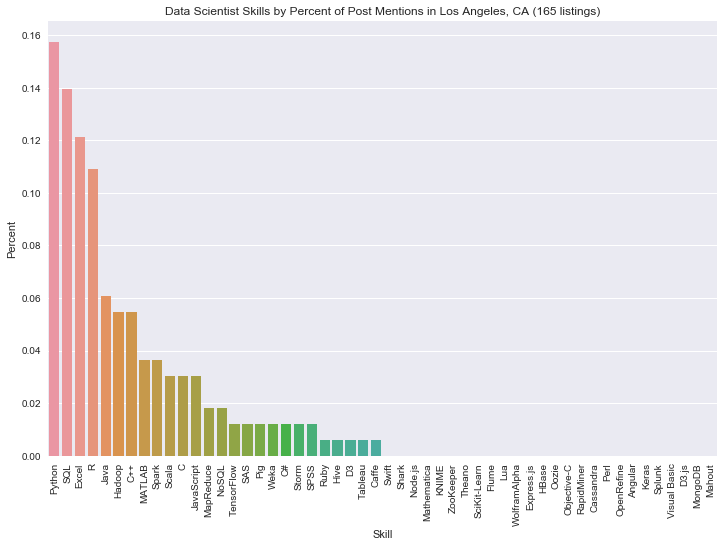

In [11]:
LA.skill_frequencies()

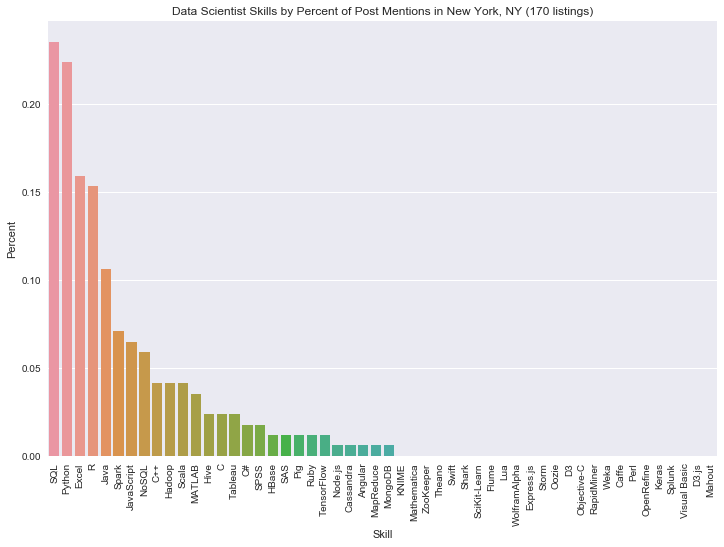

In [12]:
NY.skill_frequencies()